# Workbook

## Data Preprocessing

In [1]:
# import necessary packages
import os

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from IPython import display
import tensorflow as tf
import pandas as pd
import librosa

from sklearn.model_selection import train_test_split
from collections import Counter

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Concatenate, Dropout, BatchNormalization


# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')
# import os
# os.listdir('/content/drive/My Drive/')

# audio_path = '/content/drive/My Drive/dataset/AUDIO_NEW/'

audio_path = 'dataset/AUDIO_NEW/'

audio_types = ['breathing', 'cough', 'speech']

In [3]:
def get_directories(audio_path, audio_type):
    from pathlib import Path

    POS = os.path.join(audio_path + audio_type, 'COVID_Positive')
    NEG = os.path.join(audio_path + audio_type, 'COVID_Negative')

    # Specify the directory path
    pos_directory = Path(POS)
    neg_directory = Path(NEG)

    # List all files in the directory using iterdir()
    # pos_files = [file.name for file in pos_directory.iterdir() if file.is_file()]
    # neg_files = [file.name for file in neg_directory.iterdir() if file.is_file()]

    return pos_directory, neg_directory

In [4]:
# Load and process breathing data
pos_directory_breathing, neg_directory_breathing = get_directories(audio_path, audio_types[0])

# Load and process cough data
pos_directory_cough, neg_directory_cough = get_directories(audio_path, audio_types[1]) # audio_types[1] is 'cough'

# Load and process speech data
pos_directory_speech, neg_directory_speech = get_directories(audio_path, audio_types[2]) # audio_types[2] is 'speech'


### Define features

In [5]:
def create_mel_spectrogram(y, sr, file_path):
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=512, hop_length=128, n_mels=128)
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

    # Normalize the spectrogram
    if np.std(log_mel_spectrogram) == 0:
        print("log_mel_spectrogram == 0: ", file_path.resolve())
    
    # Normalize the spectrogram
    epsilon = 1e-6  # Small value to avoid division by zero
    log_mel_spectrogram = (log_mel_spectrogram - np.mean(log_mel_spectrogram)) / (np.std(log_mel_spectrogram) + epsilon)

    # Add channel dimension
    log_mel_spectrogram = np.expand_dims(log_mel_spectrogram, axis=-1)

    return log_mel_spectrogram

def create_zero_crossing_rate(y):
    return np.mean(librosa.feature.zero_crossing_rate(y))

def create_spectral_centroid(y, sr):
    return np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))

In [6]:
import random

def augment_audio_random(y, sr, target_length):
    """
    Applies a random augmentation with a probability to an audio signal.

    Args:
        y (numpy.ndarray): The raw audio signal.
        sr (int): Sampling rate of the audio signal.
        target_length (int): Target length for padding/truncating the audio.

    Returns:
        numpy.ndarray: Augmented audio signal padded/truncated to the target length.
    """
    if random.random() < 0.5:  # Apply augmentation with 50% probability
        augmentation_type = random.choice(["time_stretch", "pitch_shift", "add_noise"])

        if augmentation_type == "time_stretch":
            rate = random.uniform(0.9, 1.1)
            y = librosa.effects.time_stretch(y, rate=rate)

        elif augmentation_type == "pitch_shift":
            n_steps = random.randint(-2, 2)
            y = librosa.effects.pitch_shift(y=y, sr=sr, n_steps=n_steps)

        elif augmentation_type == "add_noise":
            noise = np.random.normal(0, random.uniform(0.001, 0.005), y.shape)
            y = y + noise

    zero_padding = np.zeros(max(0, target_length - len(y)), dtype=np.float32)
    y_padded = np.concatenate([y[:target_length], zero_padding], axis=0)

    return y_padded


### Split to train-test then create features

In [7]:
import random
from pathlib import Path

def split_train_test_consistent(pos_dir, neg_dir, test_size=0.2, random_seed=42):
    """
    Splits positive and negative directories into training and testing subsets with consistent shuffling.

    Args:
        pos_dirs (List[Path]): List of directories containing positive samples (e.g., cough, breathing, speech).
        neg_dirs (List[Path]): List of directories containing negative samples (e.g., cough, breathing, speech).
        test_size (float): Proportion of files to include in the test set (default is 0.2).
        random_seed (int): Random seed for reproducibility.

    Returns:
        Tuple[Tuple[List[List[Path]], List[List[Path]]], Tuple[List[List[Path]], List[List[Path]]]]:
            - ((train_pos_files_by_type, test_pos_files_by_type), (train_neg_files_by_type, test_neg_files_by_type))
    """
    np.random.seed(random_seed)  # Set seed for reproducibility

    train_pos_files_by_type = []
    test_pos_files_by_type = []
    train_neg_files_by_type = []
    test_neg_files_by_type = []

    # Process each audio type (cough, breathing, speech)
    pos_files = sorted(list(pos_dir.iterdir()))
    neg_files = sorted(list(neg_dir.iterdir()))

    # Generate consistent shuffle indices
    pos_indices = np.random.permutation(len(pos_files))
    neg_indices = np.random.permutation(len(neg_files))

    # Split indices into train and test sets
    num_pos_test = int(len(pos_files) * test_size)
    num_neg_test = int(len(neg_files) * test_size)


    train_pos_indices = pos_indices[num_pos_test:]
    test_pos_indices = pos_indices[:num_pos_test]

    train_neg_indices = neg_indices[num_neg_test:]
    test_neg_indices = neg_indices[:num_neg_test]

    # Split files into train and test sets using the indices
    train_pos_files = [pos_files[i] for i in train_pos_indices]
    test_pos_files = [pos_files[i] for i in test_pos_indices]

    train_neg_files = [neg_files[i] for i in train_neg_indices]
    test_neg_files = [neg_files[i] for i in test_neg_indices]

    # Append results for this audio type
    return (train_pos_files, test_pos_files), (train_neg_files, test_neg_files)

In [8]:
pos_breathing_path = Path(audio_path + 'breathing/COVID_Positive')
neg_breathing_path = Path(audio_path + 'breathing/COVID_Negative')

pos_cough_path = Path(audio_path + 'cough/COVID_Positive')
neg_cough_path = Path(audio_path + 'cough/COVID_Negative')

pos_speech_path = Path(audio_path + 'speech/COVID_Positive')
neg_speech_path = Path(audio_path + 'speech/COVID_Negative')

(train_pos_breathing_files, test_pos_breathing_files), (train_neg_breathing_files, test_neg_breathing_ffiles) = split_train_test_consistent(
    pos_breathing_path,
    neg_breathing_path,
    test_size=0.2,
    random_seed=42
)

(train_pos_cough_files, test_pos_breathing_files), (train_neg_cough_files, test_neg_cough_files)= split_train_test_consistent(
    pos_cough_path,
    neg_cough_path,
    test_size=0.2,
    random_seed=42
)

(train_pos_speech_files, test_pos_speech_files), (train_neg_speech_files, test_neg_speech_files) = split_train_test_consistent(
    pos_speech_path,
    neg_speech_path,
    test_size=0.2,
    random_seed=42
)

In [9]:
def create_features_splitted(pos_directory, neg_directory, target_length, augment=True):
    #print("Creating features for {0} and {1}! ".format(pos_directory, neg_directory))
    spectrograms = []
    other_features = []
    labels = []

    # Access files directly using iterdir()
    for file_path in sorted(pos_directory):
        y, sr = librosa.load(file_path, sr=16000)
        y = y[:target_length]
        y = librosa.util.normalize(y)

        zero_padding = np.zeros(target_length - len(y), dtype=np.float32)
        y = np.concatenate([y, zero_padding], axis=0)

        spectrograms.append(create_mel_spectrogram(y, sr, file_path))
        other_features.append([create_zero_crossing_rate(y), create_spectral_centroid(y, sr)])
        labels.append(1)


        ## Augment random
        if augment:
            y_augmented = augment_audio_random(y, sr, target_length)
            spectrograms.append(create_mel_spectrogram(y_augmented, sr, file_path))
            other_features.append([create_zero_crossing_rate(y_augmented), create_spectral_centroid(y_augmented, sr)])
            labels.append(1)

        ## Augment all
        # if augment:
        #     augmented_audios = augment_audio(y, sr, target_length)
        #     for aug_y in augmented_audios:
        #         spectrograms.append(create_mel_spectrogram(aug_y, sr, file_path))
        #         other_features.append([create_zero_crossing_rate(aug_y), create_spectral_centroid(aug_y, sr)])
        #         labels.append(1)
    
    positive_samples = len(labels)

    print(f"Number of positive samples: {positive_samples}")  

    for file_path in sorted(neg_directory):
        y, sr = librosa.load(file_path, sr=16000)
        y = y[:target_length]

        zero_padding = np.zeros(target_length - len(y), dtype=np.float32)
        y = np.concatenate([y, zero_padding], axis=0)

        spectrograms.append(create_mel_spectrogram(y, sr, file_path))
        other_features.append([create_zero_crossing_rate(y), create_spectral_centroid(y, sr)])
        labels.append(0)

        # if augment:
        #     y_augmented = augment_audio(y, sr, target_length)
        #     spectrograms.append(create_mel_spectrogram(y_augmented, sr, file_path))
        #     other_features.append([create_zero_crossing_rate(y_augmented), create_spectral_centroid(y_augmented, sr)])
        #     labels.append(0)

    print(f"Number of negative samples: {len(labels) - positive_samples}")           
    # print("Completed creating features for {0} and {1}! ".format(pos_directory, neg_directory))

    return spectrograms, other_features, labels

In [10]:
spectrograms_breathing_train, other_features_breathing_train, labels_breathing_train  = create_features_splitted(train_pos_breathing_files, train_neg_breathing_files, 80000)
spectrograms_breathing_test, other_features_breathing_test, labels_breathing_test  = create_features_splitted(test_pos_breathing_files, test_neg_breathing_ffiles, 80000, augment=False)
spectrograms_cough_train, other_features_cough_train, labels_cough_train  =  create_features_splitted(train_pos_cough_files, train_neg_cough_files, 96000)
spectrograms_cough_test , other_features_cough_test , labels_cough_test  =  create_features_splitted(test_pos_breathing_files, test_neg_cough_files, 96000, augment=False)
spectrograms_speech_train, other_features_speech_train, labels_speech_train  =  create_features_splitted(train_pos_speech_files, train_neg_speech_files, 160000)
spectrograms_speech_test, other_features_speech_test, labels_speech_test  = create_features_splitted(test_pos_speech_files, test_neg_speech_files, 160000, augment=False)


Number of positive samples: 276
log_mel_spectrogram == 0:  /Users/opheliasin/covid-detection/dataset/AUDIO_NEW/breathing/COVID_Negative/GDOLSUHV.flac
log_mel_spectrogram == 0:  /Users/opheliasin/covid-detection/dataset/AUDIO_NEW/breathing/COVID_Negative/HTUZHMVC.flac
log_mel_spectrogram == 0:  /Users/opheliasin/covid-detection/dataset/AUDIO_NEW/breathing/COVID_Negative/TMWZXJNT.flac
Number of negative samples: 635
Number of positive samples: 34
Number of negative samples: 158
Number of positive samples: 276
log_mel_spectrogram == 0:  /Users/opheliasin/covid-detection/dataset/AUDIO_NEW/cough/COVID_Negative/TMWZXJNT.flac
Number of negative samples: 635
Number of positive samples: 34
Number of negative samples: 158
Number of positive samples: 276
Number of negative samples: 635
Number of positive samples: 34
Number of negative samples: 158


In [11]:
# Function to pad spectrograms to the maximum time frame length
def pad_spectrogram(spectrogram, max_time_frames):
    current_time_frames = spectrogram.shape[1]  # Time frames are along axis 1
    if current_time_frames < max_time_frames:
        # Calculate padding amount
        padding_amount = max_time_frames - current_time_frames
        # Pad along the time axis (axis=1)
        padded_spectrogram = np.pad(spectrogram, ((0, 0), (0, padding_amount), (0, 0)), mode='constant')
    else:
        padded_spectrogram = spectrogram
    return padded_spectrogram

In [12]:
# Maximum time frame length across all audio types
max_time_frames = 1251

# Pad all spectrograms to the maximum time frame length
padded_spectrograms_breathing_train = [pad_spectrogram(s, max_time_frames) for s in spectrograms_breathing_train]
padded_spectrograms_breathing_test = [pad_spectrogram(s, max_time_frames) for s in spectrograms_breathing_test]
padded_spectrograms_cough_train = [pad_spectrogram(s, max_time_frames) for s in spectrograms_cough_train]
padded_spectrograms_cough_test = [pad_spectrogram(s, max_time_frames) for s in spectrograms_cough_test]
padded_spectrograms_speech_train = [pad_spectrogram(s, max_time_frames) for s in spectrograms_speech_train]
padded_spectrograms_speech_test = [pad_spectrogram(s, max_time_frames) for s in spectrograms_speech_test]

In [13]:
# # Combine spectrograms, other features, and labels for each participant
all_spectrograms_train = []
all_other_features_train = []
all_labels_train = []

# all_spectrograms_test = []
all_other_features_test = []
all_labels_test = []

for i in range(len(spectrograms_breathing_train)):  # Iterate over participants

    combined_spectrogram_train = np.concatenate(
        [padded_spectrograms_breathing_train[i], padded_spectrograms_cough_train[i], padded_spectrograms_speech_train[i]], axis=1
    )
    
    # Combine other features for breathing, coughing, and speech
    combined_other_features_train = np.concatenate(
        [other_features_breathing_train[i], other_features_cough_train[i], other_features_speech_train[i]], axis=0
    )
    
    # Assume labels are consistent across all audio types for a participant
    label_train = labels_breathing_train[i]  # You can use any of the label lists since they are consistent

#     # Append combined data to the final lists
    all_spectrograms_train.append(combined_spectrogram_train)
    all_other_features_train.append(combined_other_features_train)
    all_labels_train.append(label_train)


for i in range(len(spectrograms_breathing_test)):  # Iterate over participants
    
        # combined_spectrogram_test = np.concatenate(
        #     [padded_spectrograms_breathing_test[i], padded_spectrograms_cough_test[i], padded_spectrograms_speech_test[i]], axis=1
        # )
        
        # Combine other features for breathing, coughing, and speech
        combined_other_features_test = np.concatenate(
            [other_features_breathing_test[i], other_features_cough_test[i], other_features_speech_test[i]], axis=0
        )
        
        # Assume labels are consistent across all audio types for a participant
        label_test = labels_breathing_test[i]  # You can use any of the label lists since they are consistent
    
#         # Append combined data to the final lists
        # all_spectrograms_test.append(combined_spectrogram_test)
        all_other_features_test.append(combined_other_features_test)
        all_labels_test.append(label_test)
    

# # Convert to NumPy arrays
all_spectrograms_train = np.array(all_spectrograms_train)
all_other_features_train = np.array(all_other_features_train)
all_labels_train = np.array(all_labels_train)

# all_spectrograms_test = np.array(all_spectrograms_test)
all_other_features_test = np.array(all_other_features_test)
all_labels_test = np.array(all_labels_test)

In [41]:
# Flatten spectrograms and combine with other features
all_spectrograms_train_flattened = all_spectrograms_train.reshape(all_spectrograms_train.shape[0], -1)
X_combined = np.hstack([all_spectrograms_train_flattened, all_other_features_train])

In [15]:
del all_spectrograms_train_flattened

## Apply SMOTEENN

In [16]:
print(f"Original class distribution: {Counter(all_labels_train)}")

Original class distribution: Counter({np.int64(0): 635, np.int64(1): 276})


In [42]:
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.under_sampling import RandomUnderSampler

from collections import Counter


# enn = EditedNearestNeighbours(n_neighbors=5, kind_sel="mode") 

# smote_enn = SMOTEENN(random_state=seed,  sampling_strategy='auto')
# X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_combined, all_labels_train)


# Apply SMOTE
smote = SMOTE(sampling_strategy=0.5, random_state=seed)  # Oversample minority to 50% of majority
X_smote, y_smote = smote.fit_resample(X_combined, all_labels_train)


print(f"Resampled dataset shape: {Counter(y_smote)}")

Resampled dataset shape: Counter({np.int64(0): 635, np.int64(1): 317})
Resampled dataset shape: Counter({np.int64(0): 452, np.int64(1): 317})


In [ ]:

# Apply Random Undersampling
undersampler = RandomUnderSampler(sampling_strategy=0.7, random_state=seed)  # Undersample majority to match ratio
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_smote, y_smote)

print(f"Resampled dataset shape: {Counter(y_train_resampled)}")

In [43]:
del X_combined

In [44]:
print(f"Resampled class distribution: {Counter(y_train_resampled)}")

Resampled class distribution: Counter({np.int64(0): 452, np.int64(1): 317})


In [45]:
# Constants for updated time frames
num_mel_bands = 128
original_time_frames_breathing = 626 # prev: 622
original_time_frames_coughing = 751 # prev: 747
original_time_frames_speech = 1251 # prev: 1247
max_time_frames = 1251  # Maximum time frames across all audio types

# Total original time frames
original_total_time_frames = original_time_frames_breathing + original_time_frames_coughing + original_time_frames_speech

# Total spectrogram features
total_padded_spectrogram_features = num_mel_bands * (max_time_frames * 3)

In [46]:
# Separate resampled padded spectrograms and other features for X_train_resampled
padded_spectrograms_train_resampled = X_train_resampled[:, :total_padded_spectrogram_features]
other_features_train_resampled = X_train_resampled[:, total_padded_spectrogram_features:]

In [47]:
padded_spectrograms_train_resampled_reshaped = padded_spectrograms_train_resampled.reshape(
    padded_spectrograms_train_resampled.shape[0], num_mel_bands,
    max_time_frames * 3, 1
)


In [48]:
# Define a function to extract the original spectrograms without padding
def extract_original_spectrograms(padded_spectrograms, time_frames_breathing, time_frames_coughing, time_frames_speech):
    # Extract breathing spectrogram
    breathing = padded_spectrograms[:, :, :time_frames_breathing, :]
    
    # Extract coughing spectrogram
    coughing_start = time_frames_breathing
    coughing_end = time_frames_breathing + time_frames_coughing
    coughing = padded_spectrograms[:, :, coughing_start:coughing_end, :]
    
    # Extract speech spectrogram
    speech_start = coughing_end
    speech_end = speech_start + time_frames_speech
    speech = padded_spectrograms[:, :, speech_start:speech_end, :]
    
    return breathing, coughing, speech

# Extract the original spectrograms from the padded data
spectrograms_train_breathing, spectrograms_train_coughing, spectrograms_train_speech = extract_original_spectrograms(
    padded_spectrograms_train_resampled_reshaped,
    original_time_frames_breathing,
    original_time_frames_coughing,
    original_time_frames_speech
)

In [49]:
# Verify the shapes of the extracted spectrograms
print("Breathing Spectrogram Shape:", spectrograms_train_breathing.shape)  # Expected: (num_samples, 128, 622, 1)
print("Coughing Spectrogram Shape:", spectrograms_train_coughing.shape)   # Expected: (num_samples, 128, 747, 1)
print("Speech Spectrogram Shape:", spectrograms_train_speech.shape)       # Expected: (num_samples, 128, 1247, 1)

Breathing Spectrogram Shape: (769, 128, 626, 1)
Coughing Spectrogram Shape: (769, 128, 751, 1)
Speech Spectrogram Shape: (769, 128, 1251, 1)


In [50]:
#convert y_train_resampled and y_test to numpy arrays

y_train = np.array(y_train_resampled)

In [51]:
del X_train_resampled

## Training

- 0.49 balanced accuracy

In [52]:
# Define input for Mel spectrogram (shape: 625 time frames x 128 frequency bins x 1 channel)
mel_input_breathing = Input(shape=(128, 626, 1), name='mel_spectrogram_breathing')
mel_input_cough = Input(shape=(128, 751, 1), name='mel_spectrogram_cough')
mel_input_speech = Input(shape=(128, 1251, 1), name='mel_spectrogram_speech')


# Define CNN sub-network for Mel spectrogram
def create_cnn_subnetwork(input_layer):
    # First Convolutional Block
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_layer)
    x = BatchNormalization()(x)  # Add Batch Normalization
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)  # Add Dropout after pooling
    
    # Second Convolutional Block
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)  # Add Batch Normalization
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)  # Add Dropout after pooling
    
    # Third Convolutional Block
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)  # Add Batch Normalization
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.4)(x)  # Increase Dropout for deeper layers
    
    # Global Average Pooling
    x = GlobalAveragePooling2D()(x)

    return x

# Create CNN sub-networks for each spectrogram input
cnn_breathing_output = create_cnn_subnetwork(mel_input_breathing)
cnn_cough_output = create_cnn_subnetwork(mel_input_cough)
cnn_speech_output = create_cnn_subnetwork(mel_input_speech)

# Define input for other features (zero-crossing rate and spectral centroid)
other_input = Input(shape=(6,), name='other_features')

# Define a simple dense sub-network for other features
y = Dense(64, activation='relu')(other_input)
y = Dense(128, activation='relu')(y)
y = Dropout(0.3)(y)                  
y = Dense(128, activation='relu')(y)
y = Dense(64, activation='relu')(y)

# Concatenate both sub-networks
combined = Concatenate()([cnn_breathing_output, cnn_cough_output, cnn_speech_output, y])

# Add final classification layers
z = Dense(128, activation='relu')(combined)
z = Dropout(0.3)(z)                    # Add dropout to prevent overfitting
z = Dense(64, activation='relu')(z)
z = Dense(1, activation='sigmoid')(z)  # Binary classification

In [53]:
# Define the model with two inputs
model = tf.keras.Model(inputs=[mel_input_breathing, mel_input_cough, mel_input_speech, other_input], outputs=z)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy','recall','precision'])

# Print model summary
# model.summary()

In [55]:
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight

# EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',         # Metric to monitor (e.g., validation loss)
    patience=5,                 # Number of epochs with no improvement before stopping
    restore_best_weights=True,  # Restore the weights of the best epoch
    verbose=1                   # Print messages when early stopping is triggered
)


# # Compute class weights
# class_weights = {0: 1.0, 1: 2.0} 

In [56]:
history = model.fit(
    [spectrograms_train_breathing, spectrograms_train_coughing, spectrograms_train_speech, other_features_train_resampled],
    y_train,
    validation_split=0.1,
    epochs=10,
    batch_size=32,
    # class_weight = class_weights,
    callbacks=[early_stopping]
)

Epoch 1/10


/Users/opheliasin/covid-detection/venv/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['mel_spectrogram_breathing', 'mel_spectrogram_cough', 'mel_spectrogram_speech', 'other_features']. Received: the structure of inputs=('*', '*', '*', '*')
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 105s 4s/step - accuracy: 0.5430 - loss: 27.7384 - precision: 0.3606 - recall: 0.4534 - val_accuracy: 0.0000e+00 - val_loss: 12.1589 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 98s 4s/step - accuracy: 0.5540 - loss: 3.6107 - precision: 0.3068 - recall: 0.2980 - val_accuracy: 0.0130 - val_loss: 4.7946 - val_precision: 1.0000 - val_recall: 0.0130
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 90s 4s/step - accuracy: 0.5923 - loss: 1.7941 - precision: 0.3673 - recall: 0.2927 - val_accuracy: 0.0519 - val_loss: 2.2776 - val_precision: 1.0000 - val_recall: 0.0519
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 87s 4s/step - accuracy: 0.5575 - loss: 1.4424 - precision: 0.3309 - recall: 0.3108 - val_accuracy: 0.0260 - val_loss: 2.0116 - val_precision: 1.0000 - val_recall: 0.0260
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 101s 5s/step - accuracy: 0.6315 - loss: 0.9487 - precision: 0.4457 - recall: 0.4411 - val_accuracy: 0.0390 - val_loss: 1.8989 

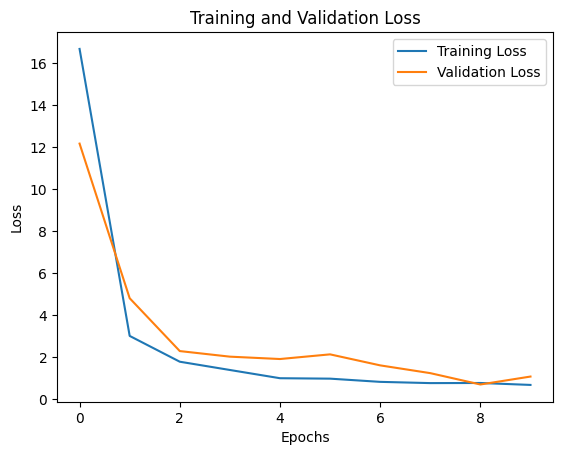

In [58]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [59]:
y_pred_train = model.predict([spectrograms_train_breathing, spectrograms_train_coughing, spectrograms_train_speech, other_features_train_resampled])


25/25 ━━━━━━━━━━━━━━━━━━━━ 16s 632ms/step


In [60]:
y_pred_train_binary = (y_pred_train > 0.6).astype(int)

In [61]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score

balanced_acc = balanced_accuracy_score(y_train, y_pred_train_binary)
print(f"Balanced Accuracy: {balanced_acc * 100:.2f}%")

accuracy_train = accuracy_score(y_train, y_pred_train_binary)

print(f"Training Accuracy: {accuracy_train * 100:.2f}%")

Balanced Accuracy: 53.69%
Training Accuracy: 61.51%


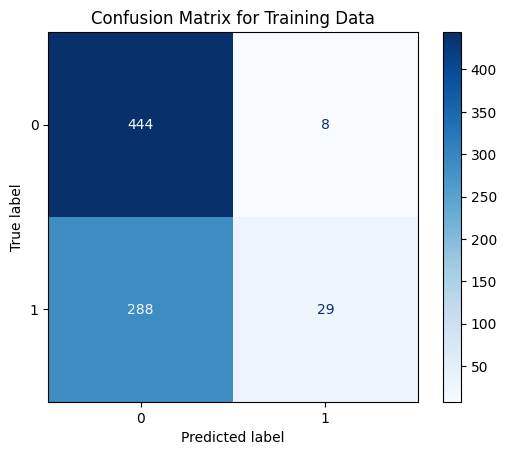

In [62]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_train, y_pred_train_binary)

# Step 4: Visualize or print the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Training Data")
plt.show()

#### Test

In [63]:
spectrograms_breathing_test = np.array(spectrograms_breathing_test)

In [64]:
spectrograms_cough_test = np.array(spectrograms_cough_test)
spectrograms_speech_test = np.array(spectrograms_speech_test)

In [65]:
y_pred_test = model.predict([spectrograms_breathing_test, spectrograms_cough_test, spectrograms_speech_test, all_other_features_test])
y_pred_test_binary = (y_pred_test > 0.6).astype(int)

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 531ms/step


In [66]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score

balanced_acc = balanced_accuracy_score(all_labels_test, y_pred_test_binary)
print(f"Balanced Accuracy: {balanced_acc}")

accuracy_train = accuracy_score(all_labels_test, y_pred_test_binary)

print(f"Testing Accuracy: {accuracy_train}")

Balanced Accuracy: 0.5943782576321668
Testing Accuracy: 0.8072916666666666


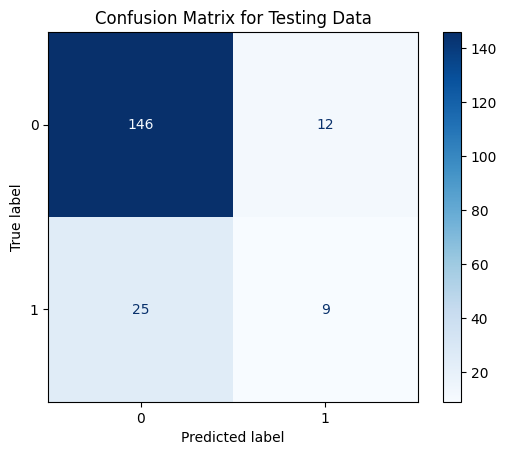

In [67]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(all_labels_test, y_pred_test_binary)

# Step 4: Visualize or print the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Testing Data")
plt.show()

In [90]:
from sklearn.metrics import classification_report

print(classification_report(all_labels_test, y_pred_test_binary))

              precision    recall  f1-score   support

           0       0.82      0.97      0.89       158
           1       0.20      0.03      0.05        34

    accuracy                           0.81       192
   macro avg       0.51      0.50      0.47       192
weighted avg       0.71      0.81      0.74       192

